In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import os 
from scipy.stats import wilcoxon, ttest_rel
from tabulate import tabulate
from functions.test_algorithms import test_slim
from slim_gsgp_lib_torch.utils.utils import train_test_split
from slim_gsgp_lib_torch.datasets.data_loader import *
datasets = [globals()[i] for i in globals() if 'load' in i][2:]
datasets = datasets[:12] + datasets[13:]  # EXCLUDE PARKINSONS

dataset_dict = {}
df_datasets = {}
for i, dataset in enumerate(datasets):
    X,y = dataset()
    name = dataset.__name__.split('load_')[1]
    # id should be a two digit number
    id = 'DA' + str(i).zfill(2)
    dataset_dict[name] = id 
    df_datasets[name] = X.shape[0], X.shape[1]

df_datasets

{'resid_build_sale_price': (372, 107),
 'istanbul': (536, 7),
 'airfoil': (1503, 5),
 'bike_sharing': (731, 13),
 'boston': (506, 13),
 'breast_cancer': (569, 30),
 'concrete_slump': (103, 7),
 'concrete_strength': (1005, 8),
 'diabetes': (442, 10),
 'efficiency_heating': (768, 8),
 'efficiency_cooling': (768, 8),
 'forest_fires': (513, 43),
 'ld50': (234, 626),
 'ppb': (131, 626),
 'bioav': (358, 241)}

In [22]:
counter = {}
for dataset_id in dataset_dict:
    id = dataset_dict[dataset_id]
    with open(f'params/{id}/scsm_11.pkl', 'rb') as f:
        unsm_11 = pickle.load(f)
    
    for algo in unsm_11:
        used = unsm_11[algo]['best_params']['depth_distribution']
        if used not in counter:
            counter[used] = 1
        else:
            counter[used] += 1

### Differences in scale

In [2]:
df_stats = pd.DataFrame()

for dataset in datasets:
    X,y = dataset()
    name = dataset.__name__.split('load_')[1]
    id = dataset_dict[name]
    n = X.shape[0]
    k = X.shape[1]

    mean_y = float(np.mean(y.numpy()))
    std_y = float(np.std(y.numpy()))
    info = {
        'Dataset': name,
        'n': n,
        'k': k,
        'mean(y)': mean_y,
        'std(y)': std_y
    }

    # Now for the variables
    means, stds = [], []
    for i in range(X.shape[1]):
        # Check the correlation of the variable with the target
        std_xi = np.std(X[:,i].numpy())
        if std_xi == 0 or std_y == 0:
            continue
        corr = np.corrcoef(X[:,i].numpy(), y.numpy())[0,1]
        if np.abs(corr) > 0.1: # 0.3:
            mean = np.mean(X[:,i].numpy())
            std = np.std(X[:,i].numpy())    
            means.append(mean)
            stds.append(std)
        else:
            continue
    if len(means) == 0:
        for i in range(X.shape[1]):
            std_xi = np.std(X[:,i].numpy())
            if std_xi == 0 or std_y == 0:
                continue
            corr = np.corrcoef(X[:,i].numpy(), y.numpy())[0,1]
            if np.abs(corr) > 0.1:
                mean = np.mean(X[:,i].numpy())
                std = np.std(X[:,i].numpy())    
                means.append(mean)
                stds.append(std)
    info['mean(X)'] = float(np.mean(means))
    info['std(X)'] = float(np.mean(std))
    df_info = pd.DataFrame(info, index=[id])
    df_info['ratio_means'] = np.abs(np.log10(np.abs(df_info['mean(y)'] / df_info['mean(X)']))) * np.sign(df_info['mean(y)'] / df_info['mean(X)'])
    df_info['ratio_stds'] = np.abs(np.log10(np.abs(df_info['std(y)'] / df_info['std(X)']))) * np.sign(df_info['std(y)'] / (df_info['std(X)']))
    df_info['sum_ratio'] = np.abs(df_info['ratio_means']) + np.abs(df_info['ratio_stds'])
    df_info = df_info.round(4)
    df_stats = pd.concat([df_stats, df_info])

# Tabulate 
df_stats = df_stats.sort_values('sum_ratio', ascending=False)
df_stats = df_stats[['Dataset', 'n', 'k', 'ratio_means', 'ratio_stds', 'sum_ratio', 'mean(y)', 'std(y)', 'mean(X)', 'std(X)']]
print(tabulate(df_stats, headers='keys', tablefmt='github'))

|      | Dataset                |    n |   k |   ratio_means |   ratio_stds |   sum_ratio |   mean(y) |    std(y) |    mean(X) |      std(X) |
|------|------------------------|------|-----|---------------|--------------|-------------|-----------|-----------|------------|-------------|
| DA08 | diabetes               |  442 |  10 |      -12.3076 |       3.2092 |     15.5169 |  152.133  |   77.0057 |    -0      |      0.0476 |
| DA00 | resid_build_sale_price |  372 | 107 |        2.5117 |       3.4936 |      6.0052 |  232.648  |  162.409  | 75571.9    | 506050      |
| DA12 | ld50                   |  234 | 626 |        0.436  |       4.4403 |      4.8763 | 1672.73   | 2019.46   |   612.96   |      0.0733 |
| DA05 | breast_cancer          |  569 |  30 |        2.0729 |       1.428  |      3.501  |    0.6274 |    0.4835 |    74.2164 |      0.018  |
| DA02 | airfoil                | 1503 |   5 |        0.6737 |       2.7198 |      3.3935 |  124.836  |    6.8964 |   588.834  |      0.0131 |

In [4]:
# Aggregate the dictionary of params and results, as they were saved in separate files
params_dict = {}
results_dict = {}
index = 12

for dataset in datasets:
    try:
        dataset_name = dataset.__name__.split('load_')[1]
        dataset_id = dataset_dict[dataset_name]
        avalaible_settings = []
        for file in os.listdir(f'results/slim/{dataset_id}'):
            # Get the different settings available 
            if len(file.split('_')) < 3:
                continue
            settings = file.split('_')[2].split('.')[0]
            if settings not in avalaible_settings:
                avalaible_settings.append(settings)
        
        for settings in avalaible_settings:
            # Check if settings already exist 
            # if os.path.exists(f'params/{dataset_id}/{settings}_{index}.pkl') and os.path.exists(f'results/slim/{dataset_id}/{settings}_{index}.pkl'):
            #     print(f"WARNING: Settings {settings} already processed for dataset {dataset_id}")
            #     continue
            dict_params = {}
            dict_results = {}
            for suffix in ['MUL_ABS', 'MUL_SIG1', 'MUL_SIG2', 'SUM_ABS', 'SUM_SIG1', 'SUM_SIG2']:
                try:
                    # Parameters
                    with open(f'params/{dataset_id}/{suffix}_{settings}.pkl', 'rb') as f:
                        params = pickle.load(f)
                    params = {suffix : params}
                    dict_params.update(params)
                    os.remove(f'params/{dataset_id}/{suffix}_{settings}.pkl')
                except Exception as e:
                    print(f"Error in parameters {dataset_id} - {settings}: {e}")

                try:
                    # Results
                    with open(f'results/slim/{dataset_id}/{suffix}_{settings}.pkl', 'rb') as f:
                        results = pickle.load(f)
                    for k, v in results.items():
                        if k not in dict_results:
                            dict_results[k] = {}
                        v = {suffix : v}
                        dict_results[k].update(v)
                    os.remove(f'results/slim/{dataset_id}/{suffix}_{settings}.pkl')

                except Exception as e:
                    print(f"Error in results {dataset_id} - {settings}: {e}")
                    continue
            
            # Dump the results
            pickle.dump(dict_params, open(f'params/{dataset_id}/{settings}_{index}.pkl', 'wb'))
            pickle.dump(dict_results, open(f'results/slim/{dataset_id}/{settings}_{index}.pkl', 'wb')) 

    except Exception as e:
        print(f"Error in processing dataset: {e}")
        continue       

In [3]:
prefixes = ['unsm_10', 'scsm_10']
dataset = 'DA03'

with open(f'results/slim/{dataset}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)

with open(f'results/slim/{dataset}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)

data1 = [(key, np.mean(times)) for key, times in results1['time'].items()]
data2 = [(key, np.mean(times)) for key, times in results2['time'].items()]

df_time = pd.DataFrame(data1, columns=['Algorithm', f'Time {prefixes[0]}'])
df_time[f'Time {prefixes[1]}'] = [v for k, v in data2]
df_time['Ratio'] = df_time[f'Time {prefixes[0]}'] / df_time[f'Time {prefixes[1]}']
df_time.set_index('Algorithm', inplace=True)
df_time

,Time unsm_10,Time scsm_10,Ratio
Algorithm,,,
MUL_ABS,95.947036,64.067613,1.497590
MUL_SIG1,80.401592,67.708161,1.187473
MUL_SIG2,71.371554,59.147195,1.206677
SUM_ABS,88.284171,69.831612,1.264244
SUM_SIG1,98.571772,49.099588,2.007589
SUM_SIG2,80.326403,53.612298,1.498283


In [4]:
def get_significance(p_value, ratio, detailed=False):
    if p_value >= 0.05:
        return 'NSD'
    elif ratio > 1:
        return '-' * (1 + int(p_value < 0.01) + int(p_value < 0.001)) if detailed else '-'
    else:
        return '+' * (1 + int(p_value < 0.01) + int(p_value < 0.001)) if detailed else '+'
    
def check_settings_availability(prefix_list):
    possible = True
    for prefix in prefix_list:
        settings, number = prefix.split('_')
        available = get_settings(number)
        if settings in available:
            continue
        else:
            print(f"Settings {prefix} not available. Choose from: {available}")
            possible = False
    
    return possible

def get_settings(n_prefix):
    settings = []
    for file in os.listdir(f'results/slim/DA00'):
        if not any(char.isdigit() for char in file):
            continue
        if file.split('_')[1].split('.pkl')[0] == str(n_prefix):
            settings.append(file.split('_')[0])
    return settings


def means_df(prefixes=['sc', 'scsm'],
             datasets=None,
             metrics=None, 
             best=False,
             decimals=3,
             table=False,
             detailed=False,
             sorted=False, 
             errors='ignore',
             quantile_threshold=None,
             main_metric='rmse'): 

    """
    A more general version of your means_df function. 
    Controlled via the 'metrics' dictionary, which maps
    a friendly name (e.g., 'rmse') to the key in the pickled results
    (e.g., 'rmse_compare' or 'mape', etc.).

    Example usage of 'metrics':
        metrics = {
            "rmse": "rmse_compare",
            "size": "size",
            "time": "time",
            "mape": "mape"
        }

    If you only want RMSE and size:
        metrics = {
            "rmse": "rmse_compare",
            "size": "size",
        }

    Aggregation (str/float): 'mean', 'median', or float between 0-1 for quantile
    """
    if check_settings_availability(prefixes) is False:
        return None

    # Validation
    if quantile_threshold and (quantile_threshold < 0 or quantile_threshold > 1):
        raise ValueError("quantile_threshold must be between 0 and 1")

    if metrics is None:
        # Default to just RMSE
        metrics = {"rmse": "rmse_compare"}  

    global dataset_dict
    if datasets is None:
        datasets = dataset_dict.keys()

    sig_test_data = {}
    data_rows = {m: [] for m in metrics.keys()}
    data_rows_std = {m: [] for m in metrics.keys()}

    # 1) Collect data from pickles
    for dataset in datasets:
        if dataset not in sig_test_data:
            sig_test_data[dataset] = {}

        for prefix in prefixes:
            if prefix not in sig_test_data[dataset]:
                sig_test_data[dataset][prefix] = {}

            with open(f"results/slim/{dataset_dict[dataset]}/{prefix}.pkl", "rb") as f:
                results = pickle.load(f)

            algorithms = results[list(metrics.values())[0]].keys()
            for algo in algorithms:
                if algo not in sig_test_data[dataset][prefix]:
                    sig_test_data[dataset][prefix][algo] = {}

                for m_name, m_key in metrics.items():
                    metric_values = results[m_key][algo] if m_key in results else None
                    if metric_values is None:
                        continue

                    metric_values = np.array(metric_values)  # Ensure metric_values is a numpy array

                    if quantile_threshold and m_name == main_metric:
                        threshold = np.quantile(metric_values, quantile_threshold)
                        below_threshold = metric_values <= threshold
                        
                        sig_test_data[dataset][prefix][algo]['_filter'] = below_threshold
                        
                        filtered_values = metric_values[below_threshold]
                        agg_val = np.mean(filtered_values) if filtered_values.size > 0 else np.nan
                        std_val = np.std(filtered_values) if filtered_values.size > 0 else np.nan
                    elif quantile_threshold and m_name != main_metric:
                        below_threshold = sig_test_data[dataset][prefix][algo].get('_filter', [])
                        
                        filtered_values = metric_values[below_threshold]
                        agg_val = np.mean(filtered_values) if filtered_values.size > 0 else np.nan
                        std_val = np.std(filtered_values) if filtered_values.size > 0 else np.nan
                    else:
                        agg_val = np.mean(metric_values)
                        std_val = np.std(metric_values)


                    data_rows[m_name].append({
                        "Dataset": dataset,
                        "Algorithm": algo,
                        f"{m_name}_{prefix}": agg_val
                    })
                    data_rows_std[m_name].append({
                        "Dataset": dataset,
                        "Algorithm": algo,
                        f"{m_name}_std_{prefix}": std_val
                    })

                    sig_test_data[dataset][prefix][algo][m_name] = np.array(metric_values)

    # 2) Build pivot tables for each metric
    df_dict = {}
    for m_name in metrics.keys():
        df_means = pd.DataFrame(data_rows[m_name])
        if not df_means.empty:
            df_means = df_means.pivot_table(
                index=["Dataset", "Algorithm"],
                values=[f"{m_name}_{p}" for p in prefixes],
                aggfunc="first"
            ).reset_index()
            df_means = df_means[
                ["Dataset", "Algorithm"] + [f"{m_name}_{p}" for p in prefixes]
            ]
        else:
            df_means = pd.DataFrame(columns=["Dataset", "Algorithm"] + [f"{m_name}_{p}" for p in prefixes])

        df_stds = pd.DataFrame(data_rows_std[m_name])
        if not df_stds.empty:
            df_stds = df_stds.pivot_table(
                index=["Dataset", "Algorithm"],
                values=[f"{m_name}_std_{p}" for p in prefixes],
                aggfunc="first"
            ).reset_index()
            df_stds = df_stds[
                ["Dataset", "Algorithm"] + [f"{m_name}_std_{p}" for p in prefixes]
            ]
        else:
            df_stds = pd.DataFrame(columns=["Dataset", "Algorithm"] + [f"{m_name}_std_{p}" for p in prefixes])

        df_merged = pd.merge(df_means, df_stds, on=["Dataset", "Algorithm"], how="outer")
        df_dict[m_name] = df_merged

    # 3) Compute ratio columns if exactly 2 prefixes are given (or you can adapt for more)
    if len(prefixes) == 2:
        for m_name in metrics.keys():
            col_a = f"{m_name}_{prefixes[0]}"
            col_b = f"{m_name}_{prefixes[1]}"
            if col_a in df_dict[m_name].columns and col_b in df_dict[m_name].columns:
                df_dict[m_name][f"ratio_{m_name}"] = (
                    df_dict[m_name][col_a] / df_dict[m_name][col_b]
                )

    # 4) Compute significance using Wilcoxon for each dataset, algo, metric,
    for m_name in metrics.keys():
        df_dict[m_name].set_index(["Dataset", "Algorithm"], inplace=True)

    for dataset in sig_test_data.keys():
        for algo in sig_test_data[dataset][prefixes[0]].keys():
            for m_name in metrics.keys():
                base_data = sig_test_data[dataset][prefixes[0]][algo].get(m_name, None)
                if base_data is None:
                    continue
                for px in prefixes[1:]:
                    comp_data = sig_test_data[dataset][px][algo].get(m_name, None)
                    if comp_data is None:
                        continue
                    min_len = min(len(base_data), len(comp_data))
                    base_vals = base_data[:min_len]
                    comp_vals = comp_data[:min_len]
                    try:
                        _, p_value = wilcoxon(
                            np.round(comp_vals - base_vals, decimals=8),
                            zero_method="pratt",
                            alternative="two-sided",
                            method="approx"
                        )
                    except Exception as e:
                        print(f"Error in significance test: {e}, {dataset}, {algo}, prefix {px}") if errors == 'raise' else None
                        print("Base vals:", base_vals, "Comp vals:", comp_vals) if errors == 'raise' else None
                        p_value = 1
                    ratio_col = f"ratio_{m_name}"
                    ratio_val = None
                    if ratio_col in df_dict[m_name].columns:
                        ratio_val = df_dict[m_name].loc[(dataset, algo), ratio_col]
                    significance = get_significance(
                        p_value, ratio_val if ratio_val is not None else 1.0,
                        detailed=detailed
                    )
                    df_dict[m_name].loc[(dataset, algo), f"{m_name}_significance"] = significance
    for m_name in metrics.keys():
        df_dict[m_name].reset_index(inplace=True)

    # 5) Combine all metric frames into one “combined” DataFrame
    df_combined = None
    for i, (m_name, df_m) in enumerate(df_dict.items()):
        if i == 0:
            df_combined = df_m
        else:
            df_combined = pd.merge(df_combined, df_m, on=["Dataset", "Algorithm"], how="outer")

    if df_combined is not None:
        df_combined = df_combined.round(decimals)

    # 6) “Best” logic: if best=True, call a separate function that picks the best for each dataset
    if best and df_combined is not None:
        return _means_df_best(df_dict, prefixes, metrics, decimals, table, detailed)

    # 7) If we want to print as a table
    if table and df_combined is not None:
        for m_name in metrics.keys():
            for px in prefixes:
                mean_col = f"{m_name}_{px}"
                std_col = f"{m_name}_std_{px}"
                if mean_col in df_combined.columns and std_col in df_combined.columns:
                    df_combined[f"{m_name}_{px}"] = (
                        df_combined[mean_col].astype(str)
                        + " ± "
                        + df_combined[std_col].astype(str)
                    )
        df_combined = df_combined[
            [c for c in df_combined.columns if not c.endswith("_std_" + prefixes[0]) and not c.endswith("_std_" + prefixes[1])]
        ]
        df_combined.sort_values("ratio_rmse", inplace=True) if sorted else None
        print(tabulate(df_combined, headers="keys", tablefmt="fancy_grid"))
        return None

    return df_combined.set_index(["Dataset", "Algorithm"])


def _means_df_best(
    df_dict,       # dict of DataFrames for each metric, e.g. df_dict["rmse"], df_dict["size"], ...
    prefixes,      # e.g. ["sc", "scsm"]
    metrics,       # e.g. {"rmse": "rmse_compare", "size": "size", "time": "time"}
    decimals=3,
    table=False,
    detailed=False
):
    """
    1) For each dataset, find the best algorithm in terms of RMSE for each prefix independently.
    2) Gather means (and std) for that chosen algorithm in each prefix, for *all* metrics.
    3) Compare the repeated measures for the chosen prefix0-algo vs prefix1-algo with Wilcoxon,
       for each metric. 
    4) Produce a single row per dataset in the final DataFrame (with dataset as the index).
    """
    if "rmse" not in metrics:
        raise ValueError("To pick the best algorithm, 'rmse' must be one of the keys in 'metrics'.")

    df_rmse = df_dict["rmse"].copy()
    if "Dataset" not in df_rmse.columns:
        df_rmse.reset_index(inplace=True)
    best_rows = []

    def load_repeated_measures(dataset, prefix, algo, metric_key):
        """
        Loads repeated measure data from pickled results for the given dataset, prefix, and algo.
        metric_key might be 'rmse_compare' or 'size' or 'time', etc.
        Returns np.array of repeated-measure values.
        """
        dataset_id = dataset_dict[dataset]
        with open(f"results/slim/{dataset_id}/{prefix}.pkl", "rb") as f:
            results = pickle.load(f)
        return np.array(results[metric_key][algo])

    # 1) For each dataset, find the “best” algorithm for each prefix (lowest RMSE).
    all_datasets = df_rmse["Dataset"].unique()
    if len(prefixes) != 2:
        print("Note: This code is specialized for exactly 2 prefixes (e.g., sc vs scsm).")
        print("If you have more prefixes, further modifications are needed.")

    # For easier referencing, name them p0, p1
    p0, p1 = prefixes[0], prefixes[1]

    for ds in all_datasets:
        df_sub = df_rmse[df_rmse["Dataset"] == ds]

        col_p0 = f"rmse_{p0}"
        col_p1 = f"rmse_{p1}"

        if col_p0 not in df_sub.columns or col_p1 not in df_sub.columns:
            continue

        idxmin_p0 = df_sub[col_p0].idxmin()
        row_p0 = df_sub.loc[idxmin_p0]
        best_algo_p0 = row_p0["Algorithm"]

        idxmin_p1 = df_sub[col_p1].idxmin()
        row_p1 = df_sub.loc[idxmin_p1]
        best_algo_p1 = row_p1["Algorithm"]
        row_data = {
            "Dataset": ds,
            f"best_algo_{p0}": best_algo_p0,
            f"best_algo_{p1}": best_algo_p1
        }
        for m_name, m_key in metrics.items():
            df_m = df_dict[m_name].copy()
            if "Dataset" not in df_m.columns:
                df_m.reset_index(inplace=True)
            row_p0_m = df_m[
                (df_m["Dataset"] == ds) & (df_m["Algorithm"] == best_algo_p0)
            ]
            row_p1_m = df_m[
                (df_m["Dataset"] == ds) & (df_m["Algorithm"] == best_algo_p1)
            ]
            mean_col_p0 = f"{m_name}_{p0}"
            mean_col_p1 = f"{m_name}_{p1}"
            std_col_p0 = f"{m_name}_std_{p0}"
            std_col_p1 = f"{m_name}_std_{p1}"

            val_p0 = row_p0_m[mean_col_p0].iloc[0] if mean_col_p0 in row_p0_m.columns and len(row_p0_m) > 0 else np.nan
            val_p1 = row_p1_m[mean_col_p1].iloc[0] if mean_col_p1 in row_p1_m.columns and len(row_p1_m) > 0 else np.nan
            row_data[f"{m_name}_{p0}"] = val_p0
            row_data[f"{m_name}_{p1}"] = val_p1
            std_p0_val = row_p0_m[std_col_p0].iloc[0] if std_col_p0 in row_p0_m.columns and len(row_p0_m) > 0 else np.nan
            std_p1_val = row_p1_m[std_col_p1].iloc[0] if std_col_p1 in row_p1_m.columns and len(row_p1_m) > 0 else np.nan
            row_data[f"{m_name}_std_{p0}"] = std_p0_val
            row_data[f"{m_name}_std_{p1}"] = std_p1_val

            if not np.isnan(val_p0) and not np.isnan(val_p1) and val_p1 != 0:
                row_data[f"ratio_{m_name}"] = val_p0 / val_p1
            else:
                row_data[f"ratio_{m_name}"] = np.nan

            try:
                arr_p0 = load_repeated_measures(ds, p0, best_algo_p0, m_key)
                arr_p1 = load_repeated_measures(ds, p1, best_algo_p1, m_key)

                min_len = min(len(arr_p0), len(arr_p1))
                arr_p0 = arr_p0[:min_len]
                arr_p1 = arr_p1[:min_len]

                _, p_value = wilcoxon(
                    np.round(arr_p0 - arr_p1, decimals=8),
                    zero_method="pratt",
                    alternative="two-sided",
                    method="approx"
                )
                significance = get_significance(
                    p_value, row_data[f"ratio_{m_name}"], detailed=detailed
                )
                row_data[f"{m_name}_significance"] = significance
            except Exception as e:
                row_data[f"{m_name}_significance"] = "!"

        best_rows.append(row_data)
    best_df = pd.DataFrame(best_rows)
    if best_df.empty:
        print("No best data found (best_df is empty).")
        return best_df
    numeric_cols = best_df.select_dtypes(include=[np.number]).columns
    best_df[numeric_cols] = best_df[numeric_cols].round(decimals)
    best_df.set_index("Dataset", inplace=True)
    if table:
        for m_name in metrics.keys():
            for px in prefixes:
                mean_col = f"{m_name}_{px}"
                std_col = f"{m_name}_std_{px}"
                if mean_col in best_df.columns and std_col in best_df.columns:
                    best_df[mean_col] = (
                        best_df[mean_col].astype(str)
                        + " ± "
                        + best_df[std_col].astype(str)
                    )

        std_cols = [c for c in best_df.columns if "_std_" in c]
        best_df.drop(columns=std_cols, inplace=True, errors="ignore")
        best_df.sort_values("ratio_rmse", inplace=True)
        print(tabulate(best_df, headers="keys", tablefmt="fancy_grid", floatfmt=f".{decimals}f"))
        return None

    return best_df.sort_values("ratio_rmse")

In [4]:
metrics = {
    "rmse": "rmse_compare",
    "size": "size",
}

means_df(prefixes=['unsm_11', 'un_11'],
         metrics=metrics,
         best=True,
         # quantile_threshold=0.5, 
         # main_metric='rmse', 
         table=True)

╒════════════════════════╤═════════════════════╤═══════════════════╤══════════════════╤════════════════════╤══════════════╤═════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╕
│ Dataset                │ best_algo_unsm_11   │ best_algo_un_11   │ rmse_unsm_11     │ rmse_un_11         │   ratio_rmse │ rmse_significance   │ size_unsm_11    │ size_un_11      │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════════╪═══════════════════╪══════════════════╪════════════════════╪══════════════╪═════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ SUM_SIG1            │ MUL_SIG2          │ 0.0 ± 0.0        │ 842.24 ± 500.114   │        0.000 │ +                   │ 9.92 ± 12.967   │ 148.36 ± 65.179 │        0.067 │ +                   │
├────────────────────────┼─────────────────────┼───────────────────┼──────────────────┼────────────────────┼──────────────┼─

In [126]:
for dataset in dataset_dict.keys():
    dataset_id = dataset_dict[dataset]
    with open(f'results/slim/{dataset_id}/unsm_11.pkl', 'rb') as f:
        results_un = pickle.load(f)['rmse_compare']

    with open(f'results/slim/{dataset_id}/scsm_11.pkl', 'rb') as f:
        results_sc = pickle.load(f)['rmse_compare']

    best_un, best_sc = 100000, 100000
    for algo in results_un.keys():
        un = results_un[algo]
        sc = results_sc[algo]
        # Get the 5% percentile
        un_5 = np.percentile(un, 10)
        sc_5 = np.percentile(sc, 10)

        if un_5 < best_un:
            best_un = un_5
        if sc_5 < best_sc:
            best_sc = sc_5

    ratio = best_un / best_sc
    print(f"Dataset: {dataset}, Ratio: {ratio}")

Dataset: resid_build_sale_price, Ratio: 1.5390494047080014
Dataset: istanbul, Ratio: 1.0171059622346472
Dataset: airfoil, Ratio: 1.1360990955229273
Dataset: bike_sharing, Ratio: 0.0
Dataset: boston, Ratio: 1.01041407677942
Dataset: breast_cancer, Ratio: 0.9520697080936293
Dataset: concrete_slump, Ratio: 1.220164178707621
Dataset: concrete_strength, Ratio: 1.0413043112479285
Dataset: diabetes, Ratio: 1.0514142442142698
Dataset: efficiency_heating, Ratio: 0.9698029747472843
Dataset: efficiency_cooling, Ratio: 1.0730155834604511
Dataset: forest_fires, Ratio: 1.01312502017106
Dataset: ld50, Ratio: 0.9869642425613578
Dataset: ppb, Ratio: 1.051428914651418
Dataset: bioav, Ratio: 1.0141064999348377


In [133]:
metrics = {
    "rmse": "rmse_compare",
    # "rmse": "rmse",
    "size": "size",
    "time": "time",
}
df = means_df(
    prefixes=["unsm_11", "un_11"],
    datasets=None,
    metrics=metrics,
    best=False,
    decimals=3,
    table=False,
    detailed=False,
    sorted=False,
)

df.loc['resid_build_sale_price']

,rmse_unsm_11,rmse_un_11,rmse_std_unsm_11,rmse_std_un_11,ratio_rmse,rmse_significance,size_unsm_11,size_un_11,size_std_unsm_11,size_std_un_11,ratio_size,size_significance,time_unsm_11,time_un_11,time_std_unsm_11,time_std_un_11,ratio_time,time_significance
Algorithm,,,,,,,,,,,,,,,,,,
MUL_ABS,64.560,153.543,8.713,32.037,0.420,+,38.60,127.04,6.861,16.292,0.304,+,50.537,49.285,2.446,0.634,1.025,-
MUL_SIG1,67.617,141.783,2.262,32.956,0.477,+,62.88,143.22,4.869,5.504,0.439,+,42.508,37.589,0.654,0.505,1.131,-
MUL_SIG2,71.098,151.262,2.380,32.964,0.470,+,83.48,212.26,9.542,17.667,0.393,+,46.721,46.091,0.512,0.637,1.014,-
SUM_ABS,68.246,153.006,7.800,33.657,0.446,+,270.26,140.06,24.066,15.292,1.930,-,54.999,48.038,0.841,0.632,1.145,-
SUM_SIG1,72.012,152.260,1.373,33.563,0.473,+,20.24,176.86,1.365,14.584,0.114,+,41.528,40.027,0.386,0.549,1.038,-
SUM_SIG2,67.742,153.026,2.981,33.646,0.443,+,19.68,142.16,1.618,14.495,0.138,+,43.950,45.021,0.514,0.500,0.976,+


In [12]:
metrics = {
    "rmse": "rmse_compare",
    # "rmse": "rmse",
    "size": "size",
    "time": "time",
}
df = means_df(
    prefixes=["unsm_11", "un_11"],
    datasets=None,
    metrics=metrics,
    best=False,
    decimals=3,
    table=False,
    detailed=False,
    sorted=False,
)

df.loc['resid_build_sale_price']

,rmse_unsm_11,rmse_un_11,rmse_std_unsm_11,rmse_std_un_11,ratio_rmse,rmse_significance,size_unsm_11,size_un_11,size_std_unsm_11,size_std_un_11,ratio_size,size_significance,time_unsm_11,time_un_11,time_std_unsm_11,time_std_un_11,ratio_time,time_significance
Algorithm,,,,,,,,,,,,,,,,,,
MUL_ABS,64.560,153.543,8.713,32.037,0.420,+,38.60,127.04,6.861,16.292,0.304,+,50.537,49.285,2.446,0.634,1.025,-
MUL_SIG1,67.617,141.783,2.262,32.956,0.477,+,62.88,143.22,4.869,5.504,0.439,+,42.508,37.589,0.654,0.505,1.131,-
MUL_SIG2,71.098,151.262,2.380,32.964,0.470,+,83.48,212.26,9.542,17.667,0.393,+,46.721,46.091,0.512,0.637,1.014,-
SUM_ABS,68.246,153.006,7.800,33.657,0.446,+,270.26,140.06,24.066,15.292,1.930,-,54.999,48.038,0.841,0.632,1.145,-
SUM_SIG1,72.012,152.260,1.373,33.563,0.473,+,20.24,176.86,1.365,14.584,0.114,+,41.528,40.027,0.386,0.549,1.038,-
SUM_SIG2,67.742,153.026,2.981,33.646,0.443,+,19.68,142.16,1.618,14.495,0.138,+,43.950,45.021,0.514,0.500,0.976,+


In [8]:
def summary_results(prefixes, metrics=None, datasets=None, errors='raise'):
    if metrics is None:
        metrics = {"rmse": "rmse_compare", "size": "size", "time": "time"}
    df_normal = means_df(
        prefixes=prefixes,
        datasets=datasets,
        metrics=metrics,
        best=False,
        decimals=3,
        table=False,
        detailed=False,
        sorted=False,
        errors=errors,
    )

    df_best = means_df(
        prefixes=prefixes,
        datasets=datasets,
        metrics=metrics,
        best=True,
        decimals=3,
        table=False,
        detailed=False,
        errors=errors,
    )
    data = {}
    for m in metrics.keys():
        data[m] = {
            'sig_count': df_normal[f'{m}_significance'].value_counts(),
            'ratio': df_normal[f'ratio_{m}'].dropna(),
            'sig_count_best': df_best[f'{m}_significance'].value_counts(),
            'ratio_best': df_best[f'ratio_{m}'].dropna(),
        }
    df_significance = pd.DataFrame({
        metric: values['sig_count'] for metric, values in data.items()
    }).T.fillna(0)

    df_significance_best = pd.DataFrame({
        metric: values['sig_count_best'] for metric, values in data.items()
    }).T.fillna(0)

    df_significance['Median Ratio'] = [values['ratio'].median() for values in data.values()]
    df_significance_best['Median Ratio'] = [values['ratio_best'].median() for values in data.values()]
    df_significance['Mean Ratio'] = [values['ratio'].mean() for values in data.values()]
    df_significance_best['Mean Ratio'] = [values['ratio_best'].mean() for values in data.values()]

    for df in [df_significance, df_significance_best]:
        numeric_df = df[['+', 'NSD', '-']].astype(float) 
        row_sums = numeric_df.sum(axis=1) 

        for col in ['+', 'NSD', '-']:
            if col in df.columns:
                df[col] = numeric_df[col].astype(int).astype(str) + " (" + (
                    100 * numeric_df[col] / row_sums
                ).astype(int).astype(str) + "%)"

    table_normal_str = tabulate(
        df_significance.reset_index(),
        headers=["Metric"] + list(df_significance.columns),
        tablefmt="grid",
        showindex=False,
    )
    table_best_str = tabulate(
        df_significance_best.reset_index(),
        headers=["Metric"] + list(df_significance_best.columns),
        tablefmt="grid",
        showindex=False,
    )
    
    # Calculate table width for alignment
    table_width = max(
        max(len(line) for line in table_normal_str.splitlines()),
        max(len(line) for line in table_best_str.splitlines()),
    )

    # Center the titles relative to the table width
    title_normal = "All Significance Counts and Ratios".center(table_width)
    title_best = "Best Significance Counts and Ratios".center(table_width)

    # Add titles and split tables into lines
    lines_normal = [title_normal] + table_normal_str.splitlines()
    lines_best = [title_best] + table_best_str.splitlines()

    # Ensure both tables have the same number of lines by padding the shorter one
    max_len = max(len(lines_normal), len(lines_best))
    lines_normal += [" " * table_width] * (max_len - len(lines_normal))
    lines_best += [" " * table_width] * (max_len - len(lines_best))

    # Combine lines side by side with spacing
    side_by_side_output = [
        f"{ln:<{table_width}}    {lb}" for ln, lb in zip(lines_normal, lines_best)
    ]
    print("\n".join(side_by_side_output))



    fig, axs = plt.subplots(1, len(data), figsize=(6 * len(data), 6), sharey=False)
    if len(data) == 1:
        axs = [axs]

    for metric, values in data.items():
        q1, q3 = np.percentile(values['ratio'], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data[metric]['ratio'] = values['ratio'][
            (values['ratio'] > lower_bound) & (values['ratio'] < upper_bound)
        ]

        q1, q3 = np.percentile(values['ratio_best'], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data[metric]['ratio_best'] = values['ratio_best'][
            (values['ratio_best'] > lower_bound) & (values['ratio_best'] < upper_bound)
        ]

    for ax, (metric, values) in zip(axs, data.items()):
        ax.boxplot([values['ratio'], values['ratio_best']], tick_labels=["Normal", "Best"])
        ax.set_title(f"{metric} ratios")
        ax.set_ylabel("Ratio")
        ax.grid(axis="y")

    # Adjust layout to ensure proper spacing
    plt.tight_layout()
    plt.show()

In [10]:
get_settings(12)

['scns', 'unns']

In [97]:
dataset_dict['forest_fires']

'DA11'

In [37]:
with open('results/slim/DA00/scns_12.pkl', 'rb') as f:
    results = pickle.load(f)

len(results['rmse']['MUL_ABS'])

50

                      All Significance Counts and Ratios                                               Best Significance Counts and Ratios                      
+----------+----------+-----------+----------+----------------+--------------+    +----------+--------+-----------+---------+----------------+--------------+
| Metric   | +        | -         | NSD      |   Median Ratio |   Mean Ratio |    | Metric   | +      | -         | NSD     |   Median Ratio |   Mean Ratio |
+==========+==========+===========+==========+================+==============+    +==========+========+===========+=========+================+==============+
| rmse     | 0 (0%)   | 90 (100%) | 0 (0%)   |         20.71  |     71.9344  |    | rmse     | 0 (0%) | 15 (100%) | 0 (0%)  |         18.403 |      76.5688 |
+----------+----------+-----------+----------+----------------+--------------+    +----------+--------+-----------+---------+----------------+--------------+
| size     | 14 (15%) | 70 (77%)  | 6 (6%)   |   

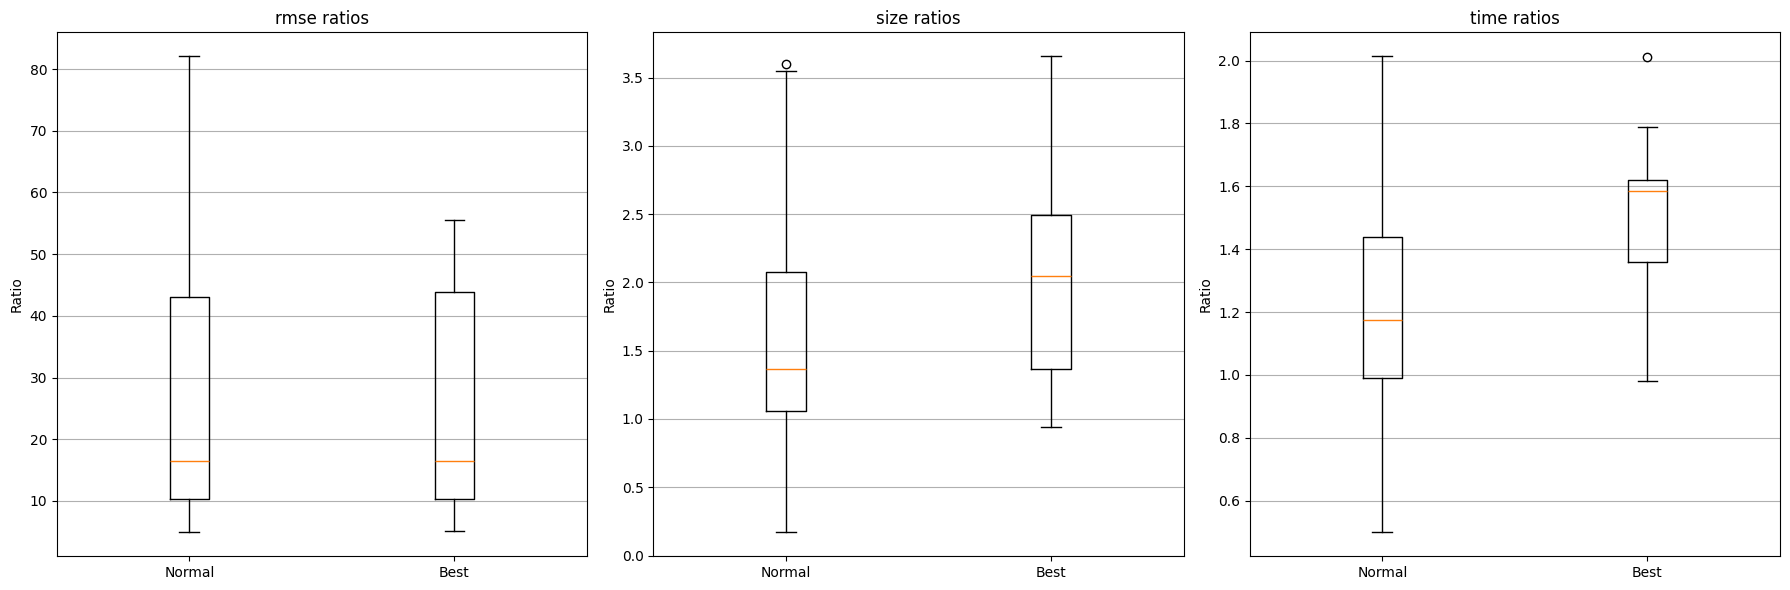

In [135]:
summary_results(
    prefixes=['unns_12', 'scns_12'],
    metrics=metrics,
    datasets=None
)

                        All Significance Counts and Ratios                                                  Best Significance Counts and Ratios                       
+----------+----------+----------+----------+----------------+--------------+        +----------+-----+---------+---------+----------+----------------+--------------+
| Metric   | +        | -        | NSD      |   Median Ratio |   Mean Ratio |        | Metric   |   ! | +       | -       | NSD      |   Median Ratio |   Mean Ratio |
+==========+==========+==========+==========+================+==============+        +==========+=====+=========+=========+==========+================+==============+
| rmse     | 31 (34%) | 10 (11%) | 49 (54%) |          0.987 |     0.952889 |        | rmse     |   1 | 3 (21%) | 0 (0%)  | 11 (78%) |          0.992 |      0.9378  |
+----------+----------+----------+----------+----------------+--------------+        +----------+-----+---------+---------+----------+----------------+--------------

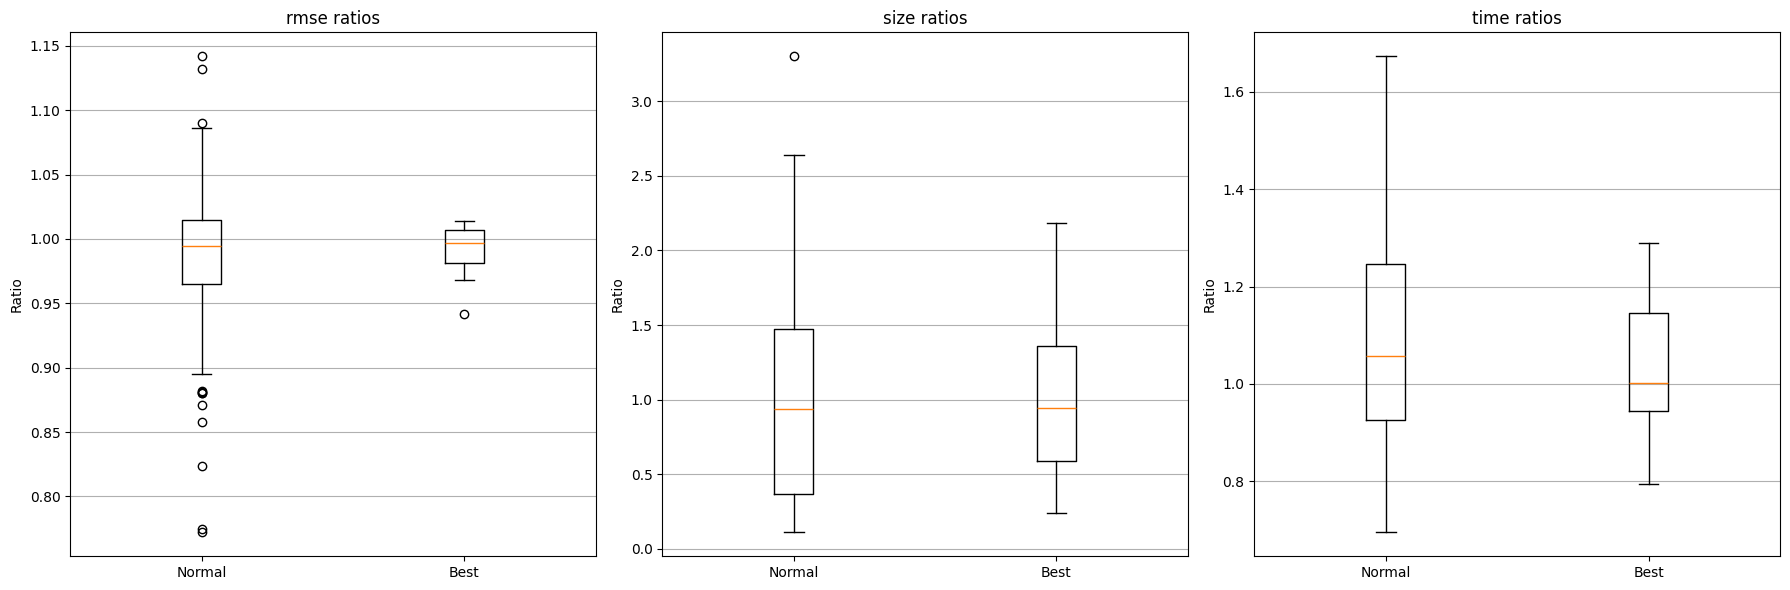

In [85]:
summary_results(
    prefixes=["scsm_11", "sc_11"],
    metrics=metrics,
    datasets=None,
)

                      All Significance Counts and Ratios                                               Best Significance Counts and Ratios                      
+----------+----------+-----------+----------+----------------+--------------+    +----------+---------+-----------+---------+----------------+--------------+
| Metric   | +        | -         | NSD      |   Median Ratio |   Mean Ratio |    | Metric   | +       | -         | NSD     |   Median Ratio |   Mean Ratio |
+==========+==========+===========+==========+================+==============+    +==========+=========+===========+=========+================+==============+
| rmse     | 22 (24%) | 45 (50%)  | 23 (25%) |         1.029  |      1.11764 |    | rmse     | 2 (13%) | 6 (40%)   | 7 (46%) |          1.027 |      1.03413 |
+----------+----------+-----------+----------+----------------+--------------+    +----------+---------+-----------+---------+----------------+--------------+
| size     | 40 (44%) | 46 (51%)  | 4 (4%)  

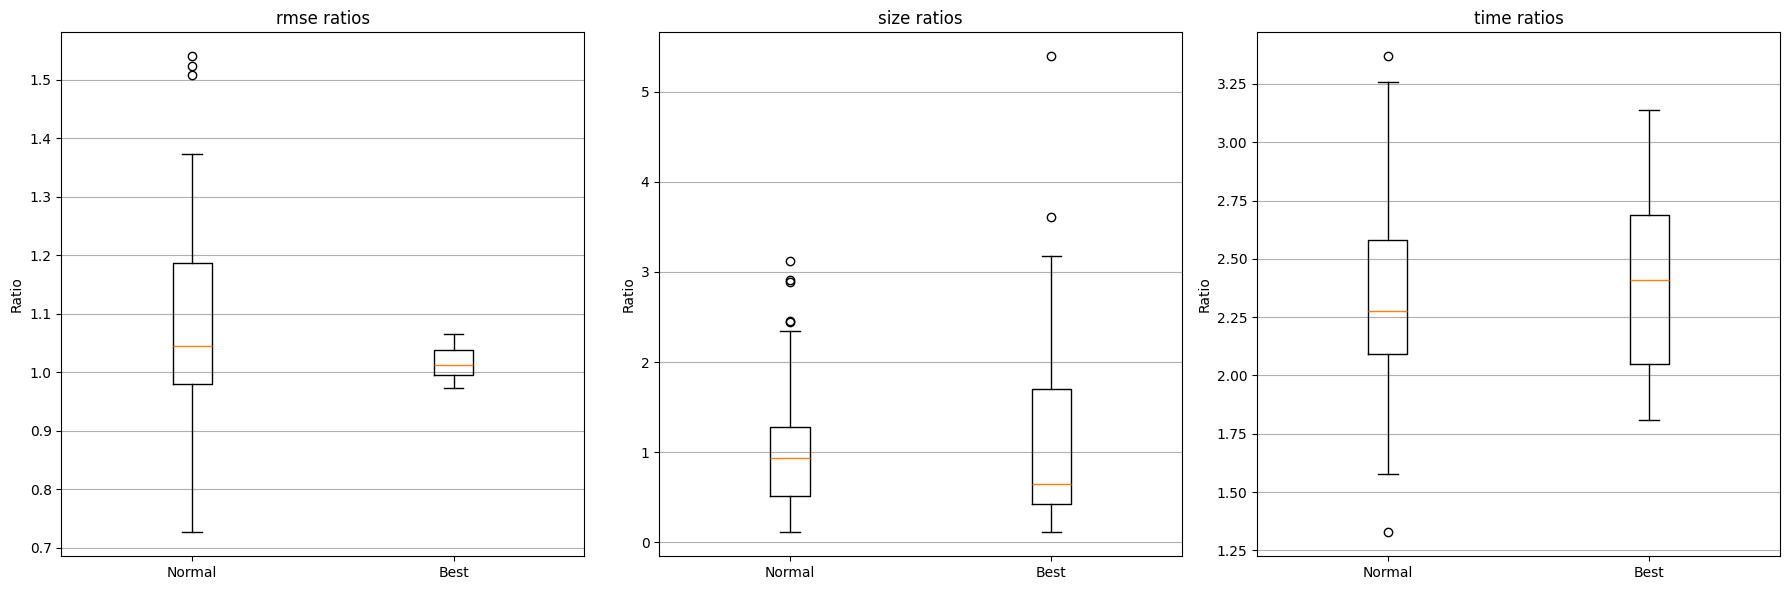

In [86]:
summary_results(
    prefixes=["unsm_11", "scsm_11"],
    metrics=metrics,
    datasets=None,
)

In [56]:
with open('params/DA14/unsmsp_11.pkl', 'rb') as f:
    params = pickle.load(f)

params['MUL_ABS']['nodes']

array([120.75,  99.  , 145.  , 217.75,  36.75, 166.75,  60.25, 102.5 ,
       158.5 , 178.  , 241.75, 114.5 , 129.5 , 200.75, 149.25, 154.25,
        40.5 ,  79.75, 112.75,  96.75,  54.25, 133.  , 176.75,  42.  ,
        55.25, 104.75,  59.5 ,  48.5 , 228.75, 100.25,  92.5 , 299.5 ,
       141.5 ,  25.5 , 228.5 , 207.75, 178.  ,  41.5 ,  56.5 , 160.75,
        91.25, 111.  , 122.25,  52.5 ,  83.5 ])

In [799]:
stds_un, stds_unsm = [], []
for i in range(15):
    i = str(i)
    if len(i) < 2:
        i = i.zfill(2)
    
    with open(f'params/DA{i}/un_10.pkl', 'rb') as f:
        params_un = pickle.load(f)
    with open(f'params/DA{i}/unsm_10.pkl', 'rb') as f:
        params_unsm = pickle.load(f)
    temp_un, temp_unsm = [], []
    for algo in params_un.keys():
        temp_un += list(params_un[algo]['scores'])
        temp_unsm += list(params_unsm[algo]['scores'])
    
    temp_un = np.array(temp_un)
    temp_unsm = np.array(temp_unsm)
    stds_un.append(np.std(temp_un, axis=0)/np.mean(temp_un, axis=0)) if np.mean(temp_un, axis=0) != 0 else stds_un.append(np.std(temp_un, axis=0))
    stds_unsm.append(np.std(temp_unsm, axis=0)/np.mean(temp_unsm, axis=0)) if np.mean(temp_unsm, axis=0) != 0 else stds_unsm.append(np.std(temp_unsm, axis=0))

print('Un standard deviations:', np.mean(stds_un, axis=0))
print('Unsm standard deviations:', np.mean(stds_unsm, axis=0))

Un standard deviations: 0.21242777
Unsm standard deviations: 0.25657824


In [58]:
def analyze_variability(instruments, datasets, params_path="params"):
    """
    Analyze the variability of scores for selected instruments and datasets.

    Parameters:
    ----------
    instruments : list of str
        Names of the instruments (e.g., ['un_10', 'unsm_10']).
    datasets : list of int
        List of dataset indices to analyze.
    params_path : str
        Path to the parameter files.

    Returns:
    -------
    dataset_variability : pd.DataFrame
        Table showing variability (mean ± std) grouped by dataset.
    algorithm_variability : pd.DataFrame
        Table showing variability (mean ± std) grouped by algorithm.
    """
    dataset_variability = []
    algorithm_variability = {}

    for dataset_idx in datasets:
        dataset_idx = str(dataset_idx).zfill(2)
        dataset_scores = {instrument: [] for instrument in instruments}

        for instrument in instruments:
            try:
                with open(f"{params_path}/DA{dataset_idx}/{instrument}.pkl", "rb") as f:
                    params = pickle.load(f)
                for algo, algo_data in params.items():
                    scores = np.array(algo_data["scores"])
                    dataset_scores[instrument].append(scores)
                    
                    # Aggregate scores by algorithm
                    if algo not in algorithm_variability:
                        algorithm_variability[algo] = {instr: [] for instr in instruments}
                    algorithm_variability[algo][instrument].append(scores)
            except FileNotFoundError:
                print(f"Warning: File {params_path}/DA{dataset_idx}/{instrument}.pkl not found.")
                continue

        # Compute variability by dataset
        dataset_row = {"dataset": dataset_idx}
        for instrument, scores_list in dataset_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"
            dataset_row[instrument] = variability
        dataset_variability.append(dataset_row)

    # Compute variability by algorithm
    algo_table = []
    for algo, instrument_scores in algorithm_variability.items():
        algo_row = {"algorithm": algo}
        for instrument, scores_list in instrument_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"
            algo_row[instrument] = variability
        algo_table.append(algo_row)

    # Convert to DataFrame
    dataset_variability_df = pd.DataFrame(dataset_variability)
    algorithm_variability_df = pd.DataFrame(algo_table)

    return dataset_variability_df, algorithm_variability_df


# Example usage
instruments = ['sc_10', 'scsm_10']
datasets = range(15)

dataset_variability, algorithm_variability = analyze_variability(instruments, datasets)

# Display the tables
print("Dataset Variability:")
print(dataset_variability)

print("\nAlgorithm Variability:")
print(algorithm_variability)

Dataset Variability:
   dataset         sc_10      scsm_10
0       00   0.06 ± 0.02  0.03 ± 0.00
1       01   0.09 ± 0.01  0.09 ± 0.01
2       02   0.15 ± 0.05  0.13 ± 0.02
3       03   0.07 ± 0.04  0.04 ± 0.03
4       04   0.13 ± 0.02  0.12 ± 0.03
5       05   0.27 ± 0.04  0.26 ± 0.05
6       06   0.28 ± 0.02  0.28 ± 0.02
7       07   0.13 ± 0.02  0.13 ± 0.02
8       08   0.19 ± 0.01  0.18 ± 0.01
9       09   0.11 ± 0.05  0.08 ± 0.02
10      10   0.11 ± 0.04  0.09 ± 0.02
11      11   0.22 ± 0.02  0.21 ± 0.01
12      12   0.24 ± 0.01  0.25 ± 0.04
13      13  4.26 ± 19.75  0.30 ± 0.03
14      14   0.29 ± 0.00  0.29 ± 0.01

Algorithm Variability:
  algorithm         sc_10      scsm_10
0   MUL_ABS   0.16 ± 0.08  0.18 ± 0.09
1  MUL_SIG1  1.32 ± 10.78  0.17 ± 0.09
2  MUL_SIG2   0.18 ± 0.08  0.14 ± 0.09
3   SUM_ABS   0.16 ± 0.08  0.16 ± 0.09
4  SUM_SIG1   0.15 ± 0.08  0.16 ± 0.08
5  SUM_SIG2   0.16 ± 0.09  0.15 ± 0.09


In [76]:
def analyze_variability_with_size(instruments, params_path="params"):
    """
    Analyze the variability of scores and sizes for selected instruments and datasets.

    Parameters:
    ----------
    instruments : list of str
        Names of the instruments (e.g., ['un_10', 'unsm_10']).
    datasets : list of int
        List of dataset indices to analyze.
    params_path : str
        Path to the parameter files.
    """
    dataset_variability = []
    algorithm_variability = {}
    dataset_sizes = []
    algorithm_sizes = {}
    datasets = range(15)

    for dataset_idx in datasets:
        dataset_idx = str(dataset_idx).zfill(2)
        dataset_scores = {instrument: [] for instrument in instruments}
        dataset_node_sizes = {instrument: [] for instrument in instruments}

        for instrument in instruments:
            try:
                with open(f"{params_path}/DA{dataset_idx}/{instrument}.pkl", "rb") as f:
                    params = pickle.load(f)
                for algo, algo_data in params.items():
                    scores = np.array(algo_data["scores"])
                    sizes = np.array(algo_data["nodes"])  # Assuming "sizes" contains node sizes
                    dataset_scores[instrument].append(scores)
                    dataset_node_sizes[instrument].append(sizes)

                    # Aggregate scores and sizes by algorithm
                    if algo not in algorithm_variability:
                        algorithm_variability[algo] = {instr: [] for instr in instruments}
                        algorithm_sizes[algo] = {instr: [] for instr in instruments}

                    algorithm_variability[algo][instrument].append(scores)
                    algorithm_sizes[algo][instrument].append(sizes)
            except FileNotFoundError:
                print(f"Warning: File {params_path}/DA{dataset_idx}/{instrument}.pkl not found.")
                continue

        # Compute variability and size by dataset
        dataset_row = {"dataset": dataset_idx}
        size_row = {"dataset": dataset_idx}

        for instrument, scores_list in dataset_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            sizes_array = np.concatenate(dataset_node_sizes[instrument]) if dataset_node_sizes[instrument] else np.array([])

            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"

            if sizes_array.size > 0:
                mean_size = np.mean(sizes_array)
                size = f"{mean_size:.2f}"
            else:
                size = "N/A"

            dataset_row[instrument] = variability
            size_row[instrument] = size

        dataset_variability.append(dataset_row)
        dataset_sizes.append(size_row)

    # Compute variability and size by algorithm
    algo_table = []
    algo_size_table = []

    for algo, instrument_scores in algorithm_variability.items():
        algo_row = {"algorithm": algo}
        size_row = {"algorithm": algo}

        for instrument, scores_list in instrument_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            sizes_array = np.concatenate(algorithm_sizes[algo][instrument]) if algorithm_sizes[algo][instrument] else np.array([])

            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"

            if sizes_array.size > 0:
                mean_size = np.mean(sizes_array)
                size = f"{mean_size:.2f}"
            else:
                size = "N/A"

            algo_row[instrument] = variability
            size_row[instrument] = size

        algo_table.append(algo_row)
        algo_size_table.append(size_row)

    # Convert to DataFrame
    dataset_variability_df = pd.DataFrame(dataset_variability).set_index("dataset")
    algorithm_variability_df = pd.DataFrame(algo_table).set_index("algorithm")
    dataset_sizes_df = pd.DataFrame(dataset_sizes).set_index("dataset")
    algorithm_sizes_df = pd.DataFrame(algo_size_table).set_index("algorithm")

    # Print the tables
    print("\nDataset Variability:")
    print(dataset_variability_df.to_string())

    print("\nAlgorithm Variability:")
    print(algorithm_variability_df.to_string())

    print("\nDataset Sizes:")
    print(dataset_sizes_df.to_string())

    print("\nAlgorithm Sizes:")
    print(algorithm_sizes_df.to_string())


# Example usage
instruments = ['unsm_11', 'un_11']
analyze_variability_with_size(instruments)


Dataset Variability:
                  unsm_11            un_11
dataset                                   
00          40.74 ± 25.28   105.44 ± 31.45
01            0.01 ± 0.00      0.01 ± 0.00
02          23.97 ± 17.06    32.83 ± 13.47
03            0.00 ± 0.00  304.52 ± 423.62
04            5.57 ± 1.18      7.53 ± 1.63
05            0.27 ± 0.05      0.28 ± 0.05
06            8.54 ± 1.32     10.23 ± 1.98
07           11.79 ± 5.92     20.67 ± 8.82
08          93.06 ± 42.53   144.68 ± 28.20
09            3.15 ± 0.76      5.91 ± 3.35
10            4.70 ± 3.45      5.26 ± 2.91
11            1.57 ± 0.58      1.43 ± 0.01
12       2096.69 ± 108.68  2203.95 ± 76.03
13           30.73 ± 2.73     32.63 ± 3.24
14          38.34 ± 11.77     44.61 ± 8.47

Algorithm Variability:
                   unsm_11            un_11
algorithm                                  
MUL_ABS     70.81 ± 348.02  179.17 ± 552.73
MUL_SIG1   100.79 ± 405.90   91.64 ± 337.22
MUL_SIG2   116.94 ± 450.37  117.21 ± 427.42
SUM

In [73]:
df_stats_ = df_stats.reset_index()
df_stats_ = df_stats_.set_index('Dataset')

df1 = pd.concat([df_stats_, df['ratio_rmse']], axis=1).drop('index', axis=1)
df1_ = df1.drop(['bike_sharing', 'diabetes'], axis=0)
df1_ = df1
df1_.corr()

,n,k,ratio_means,ratio_stds,sum_ratio,mean(y),std(y),mean(X),std(X),ratio_rmse
n,1.000000,-0.508865,0.092294,-0.027438,-0.092072,0.031479,-0.119803,-0.148708,-0.151994,0.071336
k,-0.508865,1.000000,0.067470,0.306124,-0.059260,0.106060,0.399717,-0.009781,-0.012995,0.084845
ratio_means,0.092294,0.067470,1.000000,-0.284353,-0.850538,0.061852,0.059445,0.195625,0.193029,-0.010987
ratio_stds,-0.027438,0.306124,-0.284353,1.000000,0.644438,-0.074287,0.227904,0.377764,0.373578,0.326777
sum_ratio,-0.092072,-0.059260,-0.850538,0.644438,1.000000,-0.092945,-0.006055,0.195600,0.196537,0.108377
mean(y),0.031479,0.106060,0.061852,-0.074287,-0.092945,1.000000,0.883153,-0.048176,-0.050565,-0.912179
std(y),-0.119803,0.399717,0.059445,0.227904,-0.006055,0.883153,1.000000,-0.043973,-0.048503,-0.663139
mean(X),-0.148708,-0.009781,0.195625,0.377764,0.195600,-0.048176,-0.043973,1.000000,0.999950,0.049936
std(X),-0.151994,-0.012995,0.193029,0.373578,0.196537,-0.050565,-0.048503,0.999950,1.000000,0.048864
ratio_rmse,0.071336,0.084845,-0.010987,0.326777,0.108377,-0.912179,-0.663139,0.049936,0.048864,1.000000


In [460]:
df_stats

,Dataset,n,k,ratio_means,ratio_stds,sum_ratio,mean(y),std(y),mean(X),std(X)
DA08,diabetes,442,10,-12.3076,3.2092,15.5169,152.1335,77.0057,-0.0000,0.0476
DA00,resid_build_sale_price,372,107,2.5117,3.4936,6.0052,232.6478,162.4089,75571.8984,506050.5000
DA12,ld50,234,626,0.4360,4.4403,4.8763,1672.7267,2019.4557,612.9604,0.0733
DA05,breast_cancer,569,30,2.0729,1.4280,3.5010,0.6274,0.4835,74.2164,0.0180
DA02,airfoil,1503,5,0.6737,2.7198,3.3935,124.8359,6.8964,588.8343,0.0131
DA09,efficiency_heating,768,8,0.9427,1.8793,2.8221,22.3072,10.0836,195.5102,0.1331
DA10,efficiency_cooling,768,8,0.9005,1.8538,2.7542,24.5878,9.5071,195.5102,0.1331
DA14,bioav,358,241,0.0587,2.4212,2.4799,66.3662,30.4992,57.9756,0.1156
DA11,forest_fires,513,43,1.4344,1.0268,2.4612,1.1131,1.3963,0.0409,0.1313
DA06,concrete_slump,103,7,1.2576,0.8596,2.1172,18.0485,8.7083,326.5963,63.0339


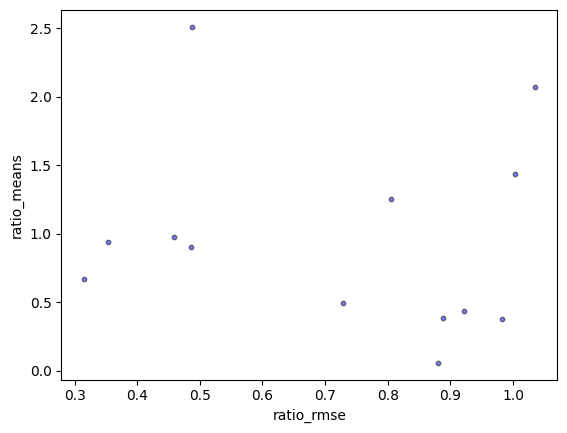

In [490]:
# Scatterplot of the columns of the DataFrame against the ratio_rmse
df1_ = df1.drop(['bike_sharing','airfoil', 'diabetes'], axis=0)
# df1_ = df1
instrument = 'ratio_means'
plt.scatter(df1_['ratio_rmse'], df1_[instrument], c='blue', alpha=0.5, label='ratio_stds', s=10, edgecolors='k', marker='o')
plt.xlabel('ratio_rmse')
plt.ylabel(instrument)
plt.show()

UNSM vs UN 
+ discrepancia entre as escalas das variáveis vs a variável target => que SM ajuda
+ n => que SM ajuda
+ k => que SM nao ajuda tanto 

UNSM vs SCSM 
+ ratio_stds => o scaling ajuda mais 

SCSM vs SC 
+ n => melhor performance 

In [ ]:
import statsmodels.api as sm
df1_ = df1.drop(['airfoil', 'bike_sharing', 'ld50'], axis=0)
X = df1_.drop(['ratio_rmse',
              #'mean(y)', 
              'mean(X)', 
              'std(y)', 
              'std(X)', 
              'k', 
              'sum_ratio', 
              'ratio_means', 
              # 'n', 
              'ratio_stds'
              ], axis=1)  
y = df1_['ratio_rmse']

X = sm.add_constant(X)
model = sm.GLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            GLS Regression Results                            
Dep. Variable:             ratio_rmse   R-squared:                       0.581
Model:                            GLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     6.231
Date:                Tue, 07 Jan 2025   Prob (F-statistic):             0.0200
Time:                        21:59:02   Log-Likelihood:                 5.0654
No. Observations:                  12   AIC:                            -4.131
Df Residuals:                       9   BIC:                            -2.676
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1453      0.141      8.113      0.0

c:\Users\Mateus\Documents\Tese\Codigo\SLIM-TEST-LITE\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
def visualize_algorithm_performance(dataset, prefixes, metrics, n_bins=14, figsize=(20, 24)):
    def replace_inf_with_nan(data):
        return np.where(np.isinf(data), np.nan, data)

    def create_dataframe(results, prefix, algorithms, metrics):
        data = []
        for algo in algorithms:
            metric_values = {metric: replace_inf_with_nan(results[key][algo]) for metric, key in metrics.items()}
            for values in zip(*metric_values.values()):
                if not any(np.isnan(v) for v in values):
                    data_point = {'algorithm': algo, 'prefix': prefix}
                    data_point.update({metric: value for metric, value in zip(metrics.keys(), values)})
                    data.append(data_point)
        return pd.DataFrame(data)

    def calculate_mean_metric(data, bins, x_metric, y_metric):
        data = data.copy()
        data[f'{x_metric}_bin'] = pd.cut(data[x_metric], bins=bins)
        return data.groupby(f'{x_metric}_bin', observed=False)[y_metric].mean().reset_index()

    dataset_id = dataset_dict[dataset]
    algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']
    
    results = []
    for prefix in prefixes:
        with open(f'results/slim/{dataset_id}/{prefix}.pkl', 'rb') as f:
            results.append(pickle.load(f))
    
    dfs = [create_dataframe(result, prefix, algorithms, metrics) for result, prefix in zip(results, prefixes)]
    df = pd.concat(dfs)

    x_metric, y_metric = list(metrics.keys())[:2]  # Use the first two metrics for x and y axes

    fig, axs = plt.subplots(3, 2, figsize=figsize)
    axs = axs.flatten()

    for i, algo in enumerate(algorithms):
        algo_data = df[df['algorithm'] == algo]
        for prefix in prefixes:
            sns.kdeplot(data=algo_data[algo_data['prefix'] == prefix], x=x_metric, ax=axs[i], label=prefix)
        
        x_min, x_max = algo_data[x_metric].min(), algo_data[x_metric].max()
        bins = np.linspace(x_min, x_max, n_bins+1)
        
        ax2 = axs[i].twinx()
        for j, prefix in enumerate(prefixes):
            mean_y = calculate_mean_metric(algo_data[algo_data['prefix'] == prefix], bins, x_metric, y_metric)
            ax2.bar(mean_y[f'{x_metric}_bin'].apply(lambda x: x.mid), mean_y[y_metric], 
                    alpha=0.2, width=(x_max-x_min)/n_bins, label=f'{prefix} Avg {y_metric.capitalize()}')
        
        axs[i].set_title(f'{algo} - ' + ' vs '.join([f"{np.nanmean(result[metrics[x_metric]][algo]):.3f}" for result in results]))
        axs[i].set_xlabel(x_metric.upper())
        axs[i].set_ylabel('Density')
        ax2.set_ylabel(f'Average {y_metric.capitalize()}')
        
        lines1, labels1 = axs[i].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    fig.suptitle(f'{dataset} - {x_metric.upper()} Distribution and Average {y_metric.capitalize()}', fontsize=18)
    plt.tight_layout(pad=2.5)
    plt.show()

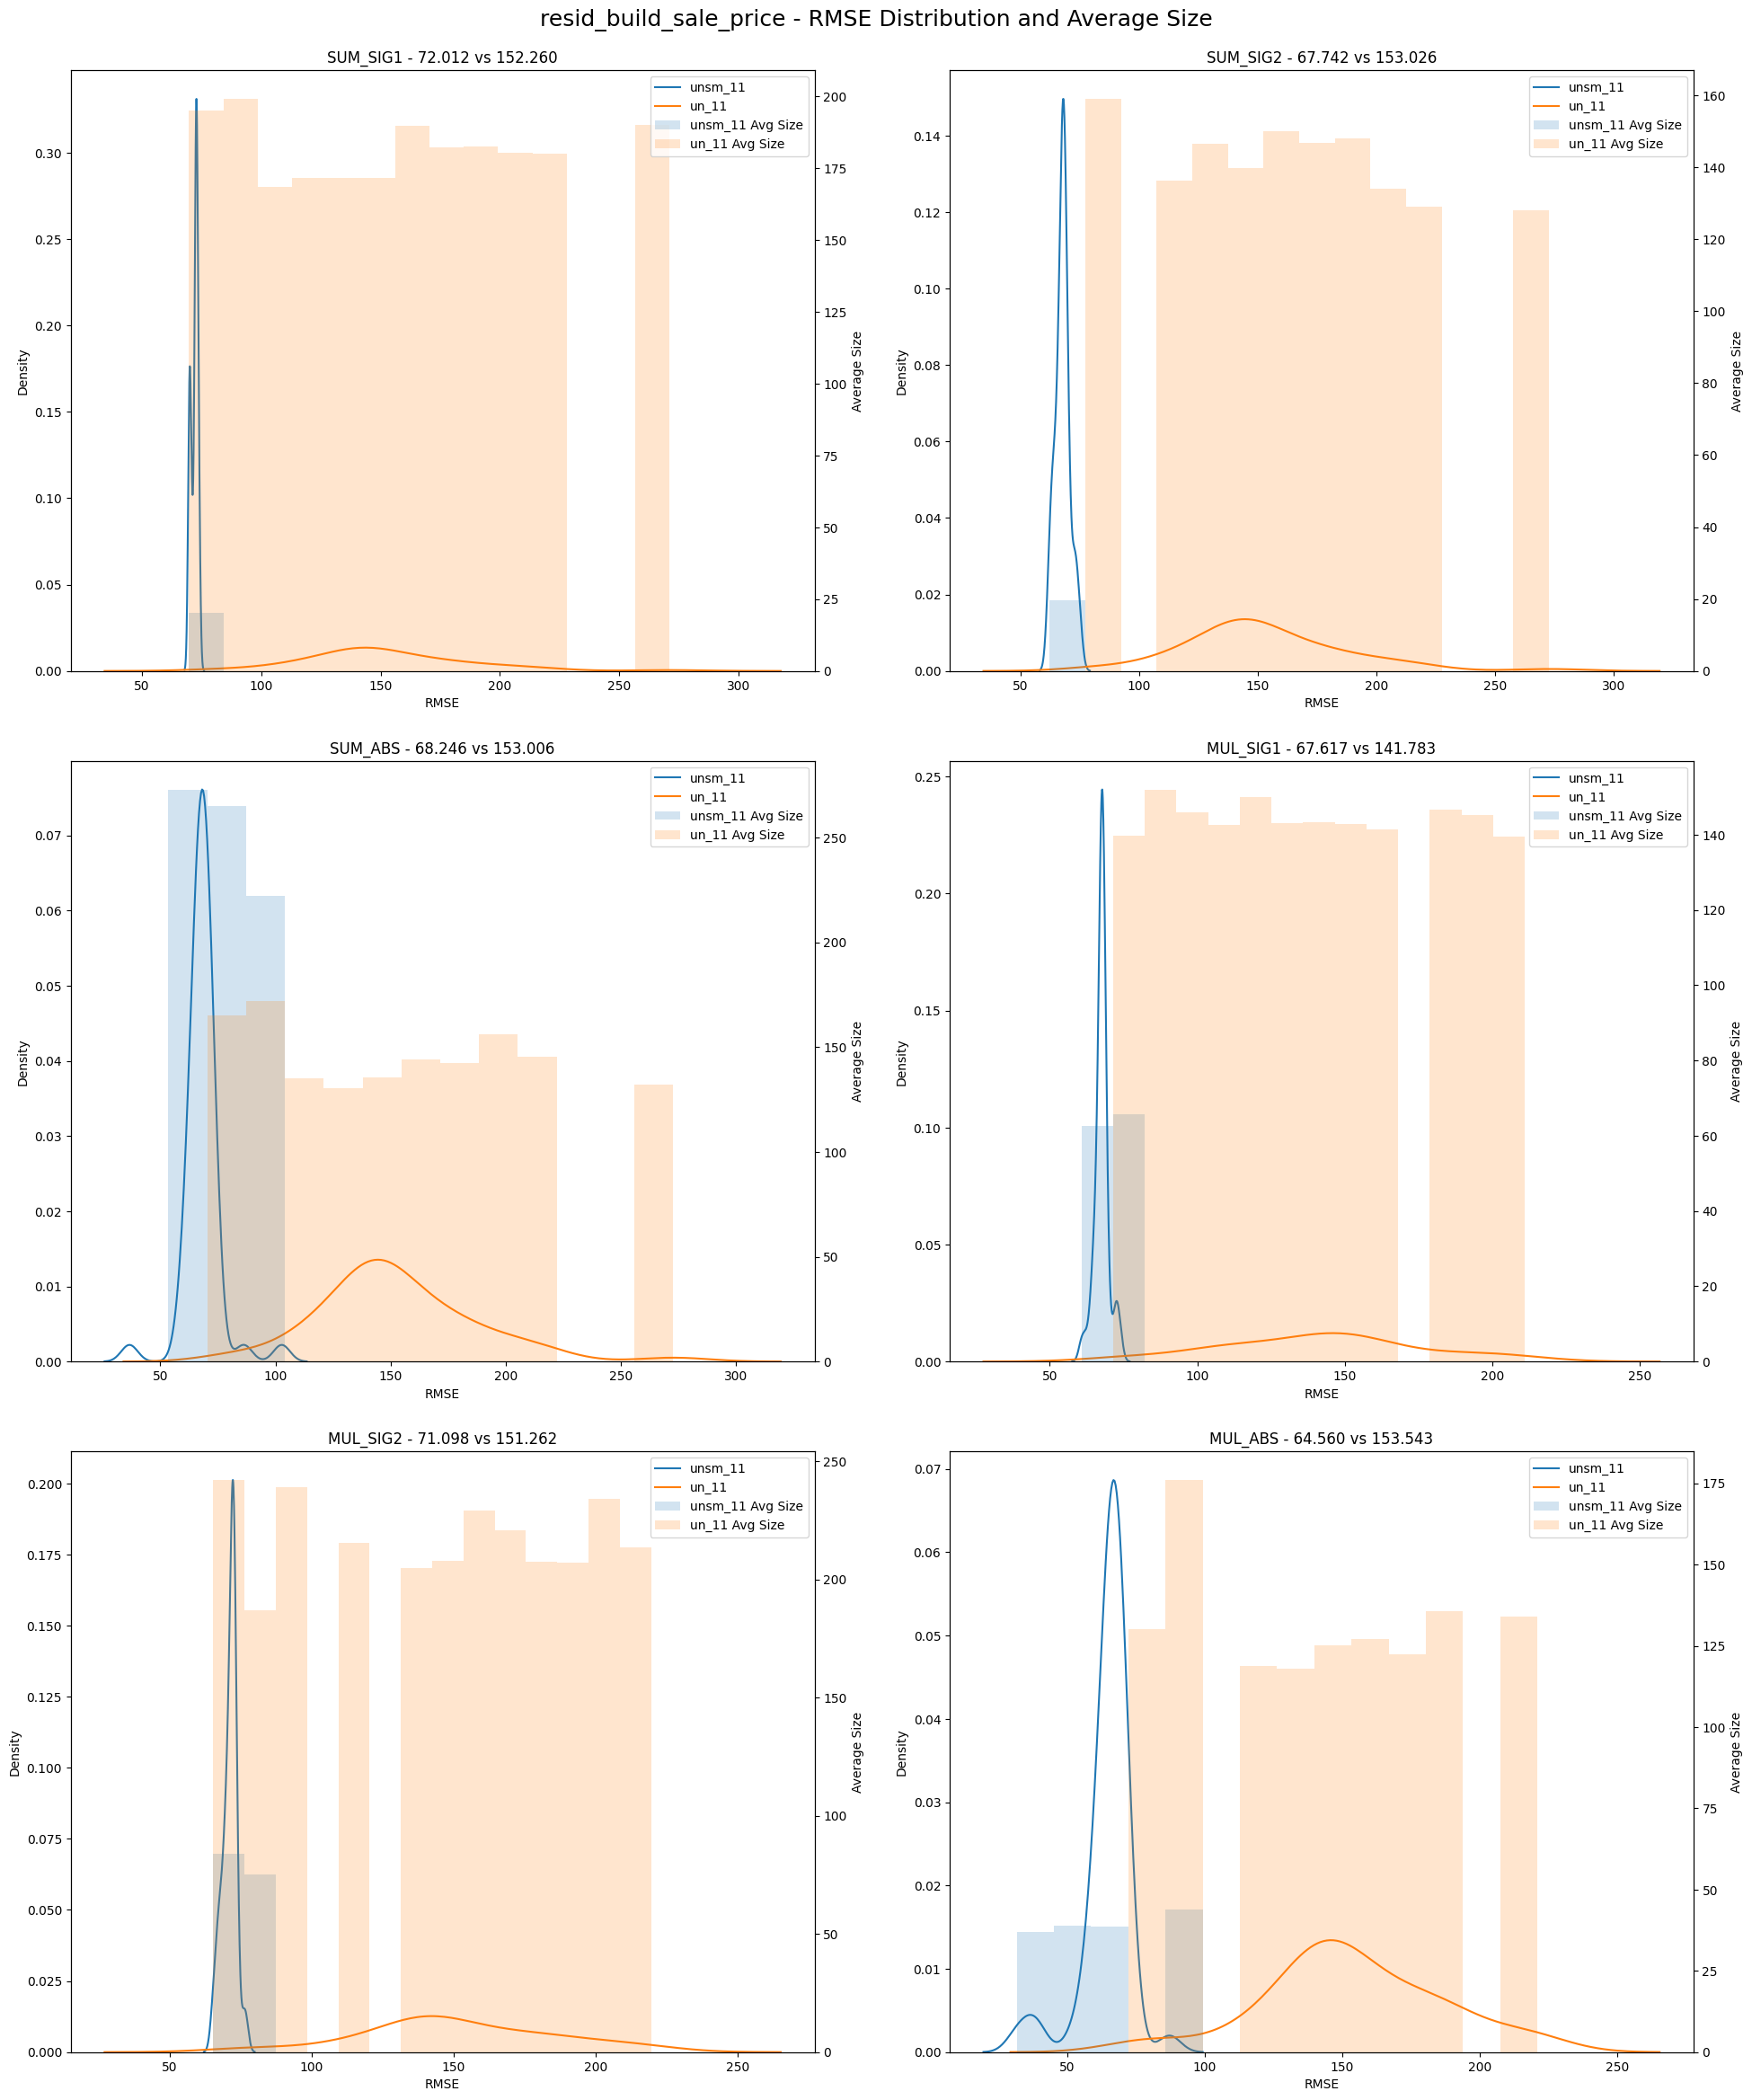

In [ ]:
metrics = {
    "rmse": "rmse_compare",
    "size": "size",
}
visualize_algorithm_performance('resid_build_sale_price', ['unsm_11', 'un_11'], metrics)

In [17]:
metrics = {
    "rmse": "rmse_compare",
    "size": "size",
}

means_df(prefixes=['unsm_11', 'scsm_11'],
         metrics=metrics,
         best=True,
         quantile_threshold=0.5, 
         main_metric='rmse', 
         table=True)

╒════════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤═══════════════════╤══════════════╤═════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╕
│ Dataset                │ best_algo_unsm_11   │ best_algo_scsm_11   │ rmse_unsm_11      │ rmse_scsm_11      │   ratio_rmse │ rmse_significance   │ size_unsm_11    │ size_scsm_11    │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════════╪═════════════════════╪═══════════════════╪═══════════════════╪══════════════╪═════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ MUL_ABS             │ SUM_SIG1            │ 0.0 ± 0.0         │ 57.642 ± 27.37    │        0.000 │ +                   │ 13.95 ± 12.546  │ 75.16 ± 26.067  │        0.186 │ +                   │
├────────────────────────┼─────────────────────┼─────────────────────┼───────────────────┼───────────────────┼──────